In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

import time
import datetime
import seaborn as sns

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error as MSE

In [2]:
###path-文件路径，pred_points-一天预测点个数
def read_data(data, pred_points):    
    data["Time"] = pd.to_datetime(data["Time"])
    data = data.sort_values("Time")

    #加上预测天，值设置为0
    last_date = data["Time"].max()
    pred_date = pd.date_range(start=last_date, periods=pred_points + 1, freq="5min")
    pred_date = pred_date[pred_date > last_date]  
    
    #future_data = pd.DataFrame({"Time": pred_date, "ByVideoId": np.zeros(len(pred_date))})
    future_data = pd.DataFrame({"Time": pred_date, "ByVideoId": np.zeros(len(pred_date))})

    # concat future data and last data
    data = pd.concat([data, future_data])
    data.set_index("Time", drop=True, inplace=True)

    
    #data.rename(columns={"ByVideoId": "y"}, inplace=True)
    data.rename(columns={"ByVideoId": "y"}, inplace=True)
    
    return data

In [3]:
###AR模型
###data-数据，test_size-测试集预测集大小，p-AR模型参数
def ar_model(data, pred_points, test_size, p):
    x = data.y.values
    train, test = x[:-pred_points * test_size], x[-pred_points * test_size:]  
    
    model_fit = AutoReg(train, lags=p).fit()
    params = model_fit.params

    
    history = x[:p] 
    future = x[p:]
    history = np.hstack(history).tolist() 

    predictions = []
    for t in range(len(future)):
        yhat = params[0]
        for i in range(p):
            yhat += params[i+1] * history[-1-i]  # history滚动提供lags
        predictions.append(yhat)
        if t<len(future)-288:
            history.append(future[t])
        else:
            history.append(yhat)
    #print(np.mean((np.array(test[:-288]) - np.array(predictions[:-288]))**2))   得到mean_squared_error, MSE
    return predictions

In [4]:
def cycle_model(data, pred_points ,cyc):
    data['shift_1'] = data.y.shift(1)
    data['diff_1'] = data.y - data.y.shift(1)    

    data["holiday"] = 0
    data.loc["2022-12-31 00:00:00":"2023-01-01 23:59:59","holiday"] = 1 
    data.loc["2023-01-18 00:00:00":"2023-01-28 23:59:59","holiday"] = 1  #春节
    #data.loc["2023-02-05 00:00:00","holiday"] = 1
    data.loc['2023-02-05','holiday'] = 1  #元宵节
    data.loc['2023-04-05','holiday'] = 1  #清明节
    data.loc["2023-04-29 00:00:00":"2023-05-03 23:59:59","holiday"] = 1  #劳动节
    data.loc["2023-06-22 00:00:00":"2023-06-24 23:59:59","holiday"] = 1  #端午节
    data.loc["2023-09-29 00:00:00":"2023-10-06 23:59:59","holiday"] = 1  #劳动节

    data['add_e'] = data.diff_1.shift(pred_points * cyc)     
    data = data.dropna()

    ### 预测天为节假日
    data_holiday = data.loc[data['holiday'] == 1]
    data_holiday['add_e'] = data_holiday.diff_1.shift(pred_points) 
    data.loc[data['holiday'] == 1] = data_holiday

    ### 预测天为非节假日
    data['holiday_shift'] = data.holiday.shift(pred_points * cyc)
    data_nonholiday = data.loc[(data['holiday_shift'] == 1) & (data['holiday'] == 0)] 
    data_nonholiday['add_e'] = np.nan
    datat = data.loc[(data['holiday_shift'] == 1) & (data['holiday'] == 0)].index + datetime.timedelta(days =- 2 * cyc)
    datat[datat >= data.index[0]]
    data[data.index.isin(datat[datat >= data.index[0]])]
    lens = len(data[data.index.isin(datat[datat >= data.index[0]])])
    if lens > 0:
        data_nonholiday['add_e'][-lens:] = data[data.index.isin(datat[datat >= data.index[0]])]['add_e']
    data[data.index.isin(data_nonholiday.index)] = data_nonholiday

    #data = data.dropna()
    data['y_pred'] = 0

    for i in range(len(data)-1,0,-pred_points):
        data.iloc[i,6] = data.iloc[i,1] 
    for j in range(1,31):
        for i in range(len(data)-pred_points * j,len(data)-pred_points * (j - 1)):
            data.iloc[i,6] = data.iloc[i-1,6] + data.iloc[i,4] 
    
    return data ,data.y_pred


In [5]:
def plt_result(data, pred ,pred_points ,days):
    plt.plot(data.index[-pred_points * days:-pred_points], data.y[-pred_points * days:-pred_points], label="y_orig")
    plt.plot(data.index[-pred_points * days:], pred[-pred_points * days:], label="y_pred")

    plt.title('AR : QPS Prediction')
    plt.xlabel('Time')
    plt.ylabel('QPS')
    plt.xticks(rotation=-10) 
    plt.legend(loc='best')

    plt.show()
    plt.tight_layout()

/var/folders/1m/x2qnkgwx5532r32fx2fkjyrw0000gn/T/ipykernel_32423/1308111594.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_holiday['add_e'] = data_holiday.diff_1.shift(pred_points)
/var/folders/1m/x2qnkgwx5532r32fx2fkjyrw0000gn/T/ipykernel_32423/1308111594.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['holiday'] == 1] = data_holiday
/var/folders/1m/x2qnkgwx5532r32fx2fkjyrw0000gn/T/ipykernel_32423/1308111594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

10368
8639


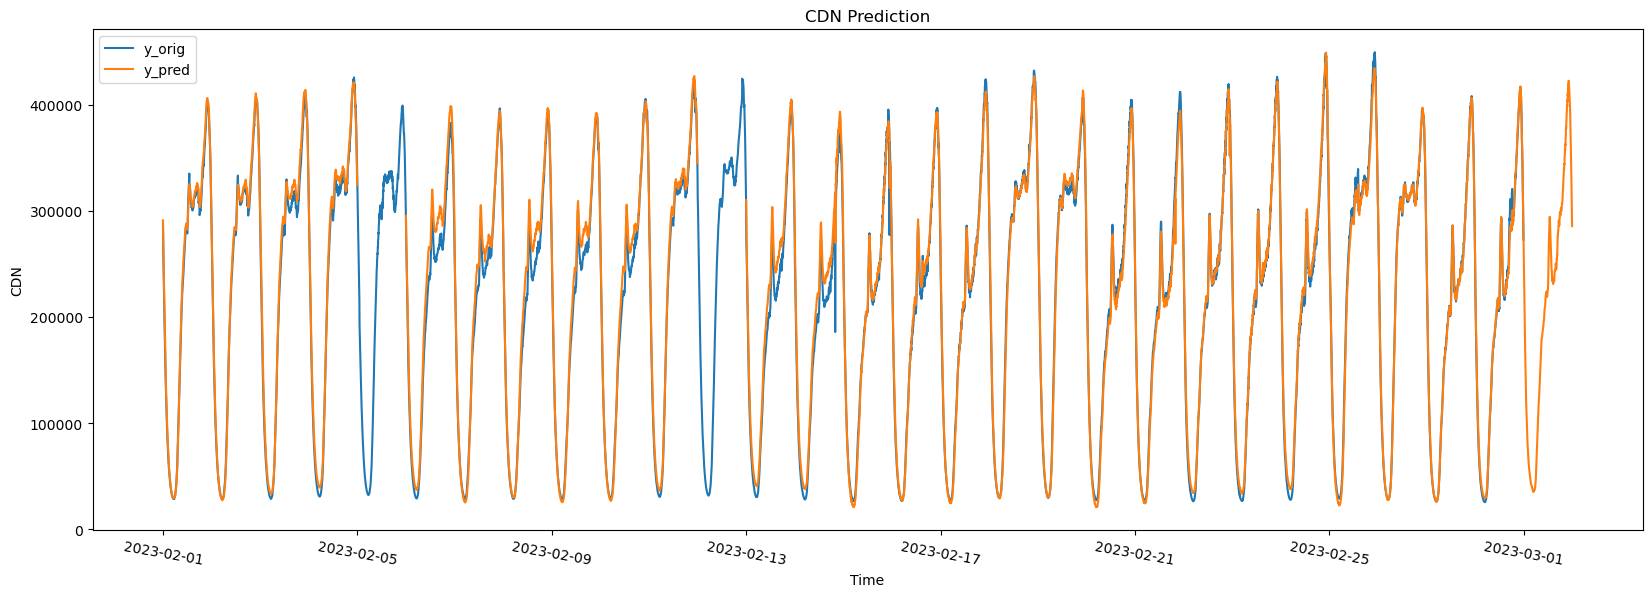

<Figure size 640x480 with 0 Axes>

In [6]:
if __name__ == "__main__":
    #path = '/Users/lxw/Downloads/CDN带宽总览-data-2023-03-01 11_14_08.csv'
    
    data1 = pd.read_csv('/Users/lxw/Downloads/请求播控 QPS 分布-data-2023-02-21-5min-30day.csv')
    data2 = pd.read_csv('/Users/lxw/Downloads/请求播控 QPS 分布-data-2023-02-28-5min.csv')

    #data2 = pd.read_csv('/Users/lxw/Downloads/CDN带宽总览-data-2023-03-01 11_14_08.csv')
    #data1 = pd.read_csv('/Users/lxw/Downloads/CDN带宽总览-data-2023-02-20 17_07_51.csv')
    data = pd.concat([data1,data2])
    
    data = read_data(data, pred_points = 288)
    ar_pred = ar_model(data, pred_points = 288, test_size = 7, p = 288)
    #plt_result(data, pred = ar_pred , pred_points = 288 ,days = 7)
    cyc_data ,cyc_pred = cycle_model(data, pred_points = 288 ,cyc = 7)
    #plt_result(data = cyc_data, pred = cyc_pred , pred_points = 288 ,days = 7)
    
    lamda=0.6
    t=29
    result = lamda * np.array(ar_pred[-288*t:]) + (1 - lamda) * cyc_pred.values[-288*t:]
    print(len(ar_pred))
    print(len(cyc_pred))
    plt.figure(figsize=(20, 6.5))
    plt.plot(cyc_data.index[-288*t:-288], cyc_data.y[-288*t:-288], label="y_orig")
    #plt.plot(cyc_data.index[-288*t:], cyc_pred[-288*t:], label="y_pred")  cyc结果
    plt.plot(cyc_data.index[-288*t:], result[-288*t:], label="y_pred")  

    plt.title('QPS Prediction')
    plt.xlabel('Time')
    plt.ylabel('QPS')
    plt.xticks(rotation=-10) 
    plt.legend(loc='best')

    plt.show()
    plt.tight_layout()